# Question 1

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime  

path = "/Users/Space/Jodi_MRT/mrt_trips_sampled.csv"
trips = pd.read_csv(path, delimiter = ',')

# duration was calculated for each origin-destination pair
trips['duration'] = ((pd.to_timedelta(trips.destination_tm.astype(str)) - pd.to_timedelta(trips.origin_tm.astype(str))).astype('timedelta64[s]') / 60).round(2) 

# change the time to datetime objects
trips['destination_tm'] = pd.to_datetime(trips['destination_tm'], format='%H:%M:%S').dt.time
trips['origin_tm'] = pd.to_datetime(trips['origin_tm'], format='%H:%M:%S').dt.time

trips.head()

,index,destination,destination_tm,origin,origin_tm,duration
0,0,Bugis DTL,10:04:47,Stevens,09:52:23,12.40
1,1,Kent Ridge,10:11:34,Sengkang,09:27:41,43.88
2,2,Tai Seng,09:35:59,Compassvale,09:03:44,32.25
3,3,Labrador Park,09:45:50,Bishan NSEW,09:14:45,31.08
4,4,Joo Koon,09:27:32,Boon Lay,09:20:36,6.93


In [10]:
unique_MRT = list(set(list(trips.destination.unique()) + list(trips.origin.unique())))
unique_MRT.sort()
print (unique_MRT)

['Admiralty', 'Aljunied', 'Ang Mo Kio', 'Bakau', 'Bangkit', 'Bartley', 'Bayfront CCL', 'Bayfront DTL', 'Beauty World', 'Bedok', 'Bishan CCL', 'Bishan NSEW', 'Boon Keng', 'Boon Lay', 'Botanic Gardens CCL', 'Botanic Gardens DTL', 'Braddell', 'Bras Basah', 'Buangkok', 'Bugis DTL', 'Bugis NSEW', 'Bukit Batok', 'Bukit Gombak', 'Bukit Panjang BPLRT', 'Bukit Panjang DTL', 'Buona Vista CCL', 'Buona Vista NSEW', 'Caldecott', 'Cashew', 'Changi Airport', 'Cheng Lim', 'Chinatown DTL', 'Chinatown NEL', 'Chinese Garden', 'Choa Chu Kang', 'Choa Chu Kang BPLRT', 'City Hall', 'Clarke Quay', 'Clementi', 'Commonwealth', 'Compassvale', 'Coral Edge', 'Cove', 'Dakota', 'Damai', 'Dhoby Ghaut NEL', 'Dhoby Ghaut NSEW', 'Dover', 'Downtown', 'Esplanade', 'Eunos', 'Expo NSEW', 'Fajar', 'Farmway', 'Farrer Park', 'Farrer Road', 'Fernvale', 'HarbourFront CCL', 'HarbourFront NEL', 'Haw Par Villa', 'Hillview', 'Holland Village', 'Hougang', 'Jelapang', 'Joo Koon', 'Jurong East', 'Kadaloor', 'Kallang', 'Kangkar', 'Keat 

From this, we can identify MRT interchanges having station IDs with similar name but ending with an additonal code.<br>
For example, the station Bishan has 'Bishan CCL' and 'Bishan NSEW'.


In [11]:
trips2 = trips
trips2['destination'] = trips2['destination'].str.replace(' CCL', '')
trips2['destination'] = trips2['destination'].str.replace(' NSEW', '')
trips2['destination'] = trips2['destination'].str.replace(' NEL', '')
trips2['destination'] = trips2['destination'].str.replace(' DTL', '')
trips2['destination'] = trips2['destination'].str.replace(' BPLRT', '')
trips2['destination'] = trips2['destination'].str.replace(' NEL', '')

trips2['origin'] = trips2['origin'].str.replace(' CCL', '')
trips2['origin'] = trips2['origin'].str.replace(' NSEW', '')
trips2['origin'] = trips2['origin'].str.replace(' NEL', '')
trips2['origin'] = trips2['origin'].str.replace(' DTL', '')
trips2['origin'] = trips2['origin'].str.replace(' BPLRT', '')
trips2['origin'] = trips2['origin'].str.replace(' NEL', '')

uni_MRT = list(set(list(trips2.destination.unique()) + list(trips2.origin.unique())))
print ('Total MRT stations: ' + str(len(uni_MRT)))

Total MRT stations: 138


The above section was included to remove the MRT line code for interchanges to reduce the number of unique origin-destination (OD) pairs. <br>
In addition, in the following section, we removed OD pairs of which the origin and destination are the same station. <br>
We also treat edges (A, B) as the same as (B, A) and only kept either one of the permutations.

In [6]:
pairs = trips2[['destination', 'origin', 'duration']]
pairs = pairs[pairs.destination != pairs.origin]
pairs[['destination', 'origin']] = pairs[['destination', 'origin']].apply(np.sort, axis = 1)

In the section below, median was used to calculate the median duration for all the unique OD pairs as it provides the most accurate time taken to tap in and out from one station to another.

I previously thought that taking the minimum would be ideal but it resulted in very inaccurate results.
<br>
Examples are shown in the table below.
<table style="width:50%">
  <tr>
    <th>Destination</th>
    <th>Origin</th> 
    <th>duration</th>
  </tr>
  <tr>
    <td>Ang Mo Kio</td>
    <td>Buangkok</td> 
    <td>1.20</td>
  </tr>
  <tr>
    <td>Bedok</td>
    <td>Bugis</td> 
    <td>1.12</td>
  </tr>
  <tr>
    <td>Changi Airport</td>
    <td>Pioneer</td> 
    <td>1.35</td>
  </tr>
</table>

In [19]:
pairs_med = pairs.groupby(['destination', 'origin'])['duration'].median().reset_index()
pairs_med.shape 

(5974, 3)

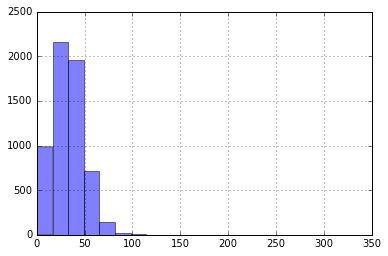

count    5974.000000
mean       33.030844
std        16.201932
min         0.650000
25%        21.271250
50%        31.885000
75%        43.600000
max       325.520000
Name: duration, dtype: float64

In [33]:
#histogram of duration of trips
pairs_med['duration'].hist(bins=20, alpha=0.5)
plt.show()

#summary of duration of trips
pairs_med['duration'].describe()

## Revision 1
While we are not supposed to know the underlying network, the stations are coloured to aid visualization.

For the first revision, with a median duration of less than 5 minutes, we are confident that the origin and destination nodes are adjacent stations given that: <br>
<ul>
  <li>the approximate train journey between 2 stations is 2 minutes</li>
  <li>the walking time from gantry to platform when entering and exiting is 1-3 minutes (average = 2 mins) </li>
</ul>

Note: we filter using median duration greater than 2 as two OD pairs with a median duration of less than 2 were found to be inaccurate.<br><br>
Our approach would be to add in more routes step by step and piece the stations together until we obtain the whole network and thus we proceed to the next revision.

In [86]:
#first revision
gph = pairs_med[(pairs_med.duration >2) & (pairs_med.duration <5)]

print ('MRT stations: ' + str(len(list(set(list(gph.destination.unique()) + list(gph.origin.unique()))))))

MRT stations: 70


<img src="https://dl.dropboxusercontent.com/s/sypl90w5pi84oo9/Screenshot%202017-01-15%2012.12.00.png?dl=0" style="width: 80%; height: 80%"/>

## Revision 2

In [87]:
#second revision
gph2 = pairs_med[(pairs_med.duration >2) & (pairs_med.duration <6)]

print ('MRT stations: ' + str(len(list(set(list(gph2.destination.unique()) + list(gph2.origin.unique()))))))

MRT stations: 115


For the second revision, with a median duration of less than 6 minutes, we will capture more routes and significantly more stations. <br> 
We are sure that there will be routes involving either 1 as well as 2 stations. To distinguish between these 2 types of routes, we plot the network graph and compare it with the graph obtained in the first revision.


<img src="https://dl.dropboxusercontent.com/s/g57xpifw2rd2l9l/Screenshot%202017-01-15%2012.14.02.png?dl=0" 
style="width: 80%; height: 80%"/>

We know that the total number of MRT stations is 138. <br>
So we are still short of 23 stations after the second revision.

## Revision 3

In [91]:
#third revision
gph3 = pairs_med[(pairs_med.duration >2) & (pairs_med.duration <7.5)]
print ('MRT stations: ' + str(len(list(set(list(gph3.destination.unique()) + list(gph3.origin.unique()))))))

gph3 = pairs_med[(pairs_med.duration >6) & (pairs_med.duration <7.5)]

MRT stations: 131


By the third revision, we would have nodes linking up 131 stations. <br>
Here, we are only filtering out new routes and storing it into gph3 (routes with median duration greater than 6 and less than 7.5 minutes)

Those in black are the new stations that were added from revision 2 to 3.

<img src="https://dl.dropboxusercontent.com/s/r01womb5f5zpnke/Screenshot%202017-01-15%2010.53.43.png?dl=0" 
style="width: 80%; height: 80%"/>

In [ ]:
#to create the graphs and export them as a gml file

#G=nx.from_pandas_dataframe(gph, 'destination', 'origin', edge_attr=['duration'], create_using=nx.Graph())
#G=nx.from_pandas_dataframe(gph2, 'destination', 'origin', edge_attr=['duration'], create_using=nx.Graph())
G=nx.from_pandas_dataframe(gph3, 'destination', 'origin', edge_attr=['duration'], create_using=nx.Graph())

#pos=nx.spring_layout(G)

#nx.draw(G,pos)
#nx.draw_networkx_edge_labels(G,pos)
#plt.show()

#export graph as gml object for visualization using Gephi

#nx.write_gml(G,"/Users/Space/Jodi_MRT/graph.gml")
#nx.write_gml(G,"/Users/Space/Jodi_MRT/graph3.gml")
#nx.write_gml(G,"/Users/Space/Jodi_MRT/graph4.gml")

Note: As we move from revision 1 to 3 and we gradually increase the duration of travel routes, there will be cases where stations that are not adjacent to each other becomes interlinked. To deduce which nodes are 1 station or 2 stations apart, we have to look at the distances (duration) between the nodes. An example is shown below.

We can deduce that Tan Kah Kee and King Albert Park are not linked as the duration between both nodes is significantly larger and a loop involving 3 stations is very unlikely.

<img src="https://dl.dropboxusercontent.com/s/iqtevu48s36scuv/Screenshot%202017-01-17%2000.43.29.png?dl=0" 
style="width: 40%; height: 40%; float:left"/>
<img src="https://dl.dropboxusercontent.com/s/c0kr5v406nzptbu/Screenshot%202017-01-17%2000.43.49.png?dl=0" 
style="width: 50%; height: 50%"/>

Also from as we move from one revision to the next, more nodes and edges will be pieced together with the new information that is made available. For example, in revision 2, Bishan is only connected to 1 station (Bradell). However, we know that Bishan is an interchange and the edges connecting Bishan to other stations are missing. From the additional edges in revision 3, as shown in the image below, we find more stations that Bishan is connected to.

<img src="https://dl.dropboxusercontent.com/s/oq774fubc3wajku/Screenshot%202017-01-15%2012.18.57.png?dl=0" 
style="width: 40%; height: 40%"/>

Following from revision 3, this methodology is repeated by fitting additional nodes and edges as more trip record information is available until the whole network is formed.

# Question 2 

Now, assuming that we have constructed the entire MRT network, we start off with the simplest case, namely that the two stations (A and B) lie on the same MRT line.

We filter the records for which destination matches station B as the destination time provides a rough gauge as to when the train arrived at each station. 

However, having all the records which destination matches station B alone is not enough as we might be making an overestimation.
First we have to filter out records which origin stations are not on the same line as station A and B.
Also, we have to take note that trains arrive at the station from both directions. To prevent over counting, we have to remove records which origin stations are after station B (those records will contain trips that are coming from the opposite direction). 

Approach:
1. Filter for records which destination == station B. 
2. Filter to remove records which origin stations are not on the same line.
3. Filter to remove records which origin stations comes after station B.
4. Group by time to count the number of exit records for a particular minute.
5. Plot the time series of exit records at B.
6. Estimate the number of trains by counting the number of peaks.

To demonstrate, we pick the following MRT line and stations:
- Line: North East Line
- Station A: Sengkang
- Station B: Dhoby Ghaut

In [6]:
trips3 = trips2[['destination', 'origin', 'destination_tm']]
trips3['destination_tm'] = trips3['destination_tm'].map(lambda t: t.strftime('%H:%M'))

#filter out trips with destination as Dhoby Ghaut
trips3 = trips3[trips3['destination'] == 'Dhoby Ghaut']

#filter out records which origin stations do not belong to the NE line
line_NE = ['Punggol', 'Sengkang', 'Buangkok', 'Hougang', 'Kovan', 'Serangoon', 'Woodleigh', 'Potong Pasir', 
          'Boon Keng', 'Farrer Park', 'Little India', 'Dhoby Ghaut', 'Clarke Quay', 'Chinatown', 'Outram Park'
          'HarbourFront']
trips3 = trips3[trips3['origin'].isin(line_NE)]

#filter out records which origin stations are from Dhoby Ghaut to HabourFront
after_B = ['Dhoby Ghaut', 'Clarke Quay', 'Chinatown', 'Outram Park', 'HarbourFront']
trips3 = trips3[~trips3['origin'].isin(after_B)]

trips3.head()

,destination,origin,destination_tm
129,Dhoby Ghaut,Buangkok,09:39
196,Dhoby Ghaut,Serangoon,09:58
283,Dhoby Ghaut,Serangoon,09:24
805,Dhoby Ghaut,Potong Pasir,09:22
841,Dhoby Ghaut,Potong Pasir,09:21


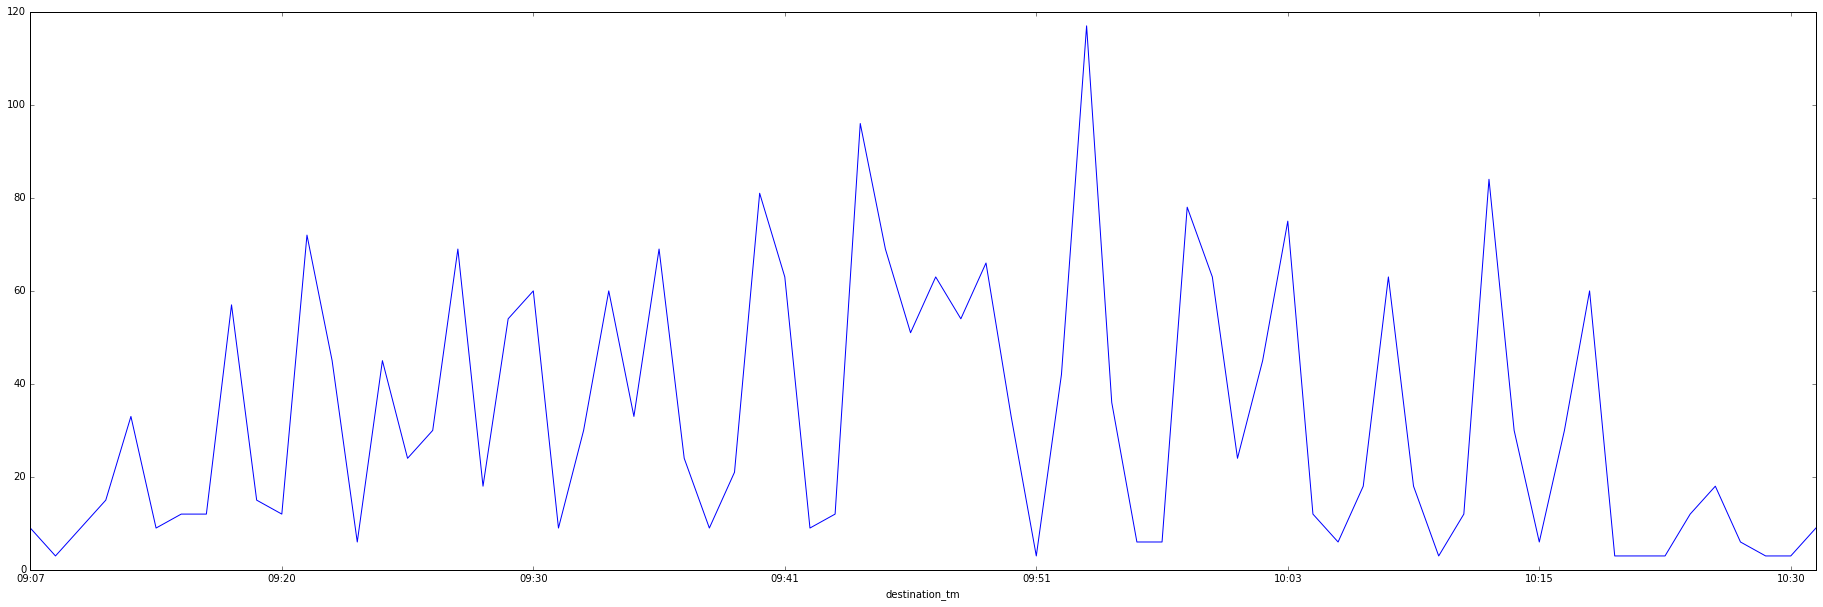

In [7]:
count_MRT = trips3[['destination', 'destination_tm']].groupby('destination_tm').count().reset_index()

# create time series of the number of commuters exiting at Dhoby Ghaut
ts_count_MRT = pd.Series(count_MRT['destination'].values, index= count_MRT['destination_tm'])
plt.figure(figsize=(32,10))

ts_count_MRT.plot()

From the time series plot above, we can observe about 22 peaks, meaning approximately 22 trains have passed from station A to B, equating a waiting time of about 4 minutes per train (90 minutes / 22).

Following this approach, if station A and B are on different lines, (for example a route from Bishan to Tanah Merah) to count the total number of trains passing through these stations, we would break down the problem into 2 parts as 2 different lines are involved.
We first count the number of trains passing from Bishan to Paya Lebar, then count the number of trains passing from Paya Lebar to Tanah Merah and add both values together.

# Question 3

Definition: The number of commuters in the train at Clementi is the number of people right when the train arrives at Clementi (no one has boarded or alighted from the train).

Assumptions: 
- There were no train delays and people who missed the train from the time the previous train departed to before the time the next train arrived made it up the next train
- Train frequency is 3 minutes (see below)
- Time taken to get to the platform from the gantry is 2 minutes
- Depending on the crowd alighting, the time taken to get from the platform from the gantry is 1 - 3 minutes


To solve this problem, we work backwards to the time when the train is at Joo Koon (the first station on the East West line) and start counting from an empty train. We then keep track of the number of people who boarded and alighted from the train at each stop at a particular time range and used this information to calculate the number of people in the train (which was at Clementi at 9.25am) at each stop.

Train arrival timings: <br>
9:08 - Joo Koon<br>
9:12 - Pioneer<br>
9:14 - Boonlay<br>
9:16 - Lakeside<br>
9:18 - Chinese Garden<br>
9:21 - Jurong East<br>
9:25 - Clementi<br>
9:27 - Dover<br>
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   .<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  .<br>
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  .<br>
9:54 - Kallang<br>
Note: The travelling time from Clementi to Kallang is about 29 minutes.

## Find approximate train frequency 
Train frequency has to be calculated to estimate the time at which the previous train left the station in order to estimate the number of commuters who missed the previous train and would board the next one.

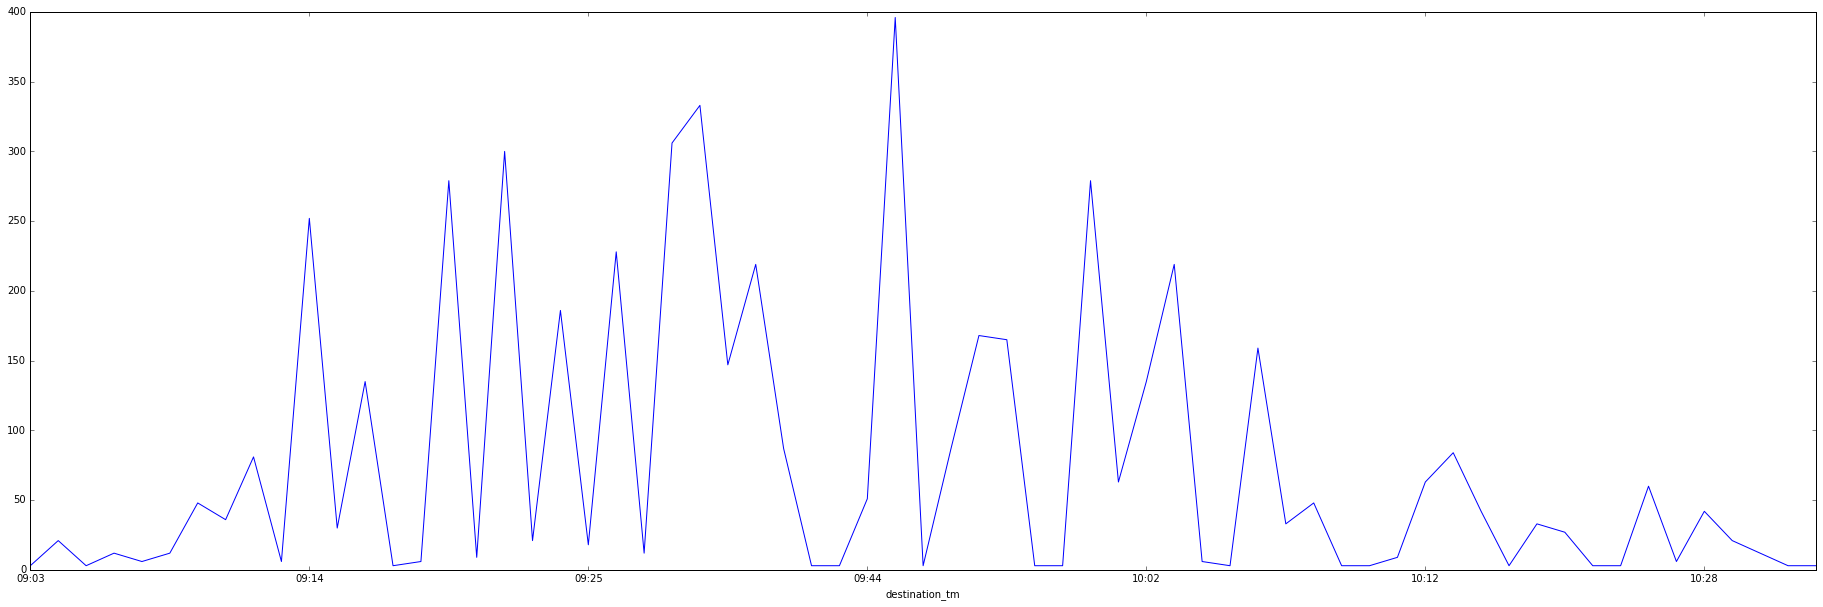

In [12]:
trips3 = trips2[['destination', 'origin', 'destination_tm']]
trips3['destination_tm'] = trips3['destination_tm'].map(lambda t: t.strftime('%H:%M'))

# Raffles Place is used as it has more people exiting and the spikes are easier to identify
trips3 = trips3[trips3['destination'] == 'Raffles Place']

find_freq = ['Joo Koon', 'Pioneer', 'Boon Lay', 'Lakeside', 'Chinese Garden', 'Jurong East', 'Clementi', 'Dover', 
          'Buona Vista', 'Commonwealth', 'Queenstown', 'Redhill', 'Tiong Bahru', 'Outram Park', 'Tanjong Pagar']
trips3 = trips3[trips3['origin'].isin(find_freq)]

count_MRT = trips3[['destination', 'destination_tm']].groupby('destination_tm').count().reset_index()
ts_count_MRT = pd.Series(count_MRT['destination'].values, index= count_MRT['destination_tm'])
plt.figure(figsize=(32,10))

#plt.figure(figsize=(8,5))

ts_count_MRT.plot()

About 30 peaks were observed, equating to a train frequency of 3 minutes.

## Filtering of trips
The records have to be filtered to obtain only commuters travelling on the east west line who boarded or alighted from stations Joo Koon to Lavender and are travelling in the direction of Joo Koon towards Pasir Ris.

In [13]:
trips4 = trips2[['destination', 'destination_tm', 'origin', 'origin_tm']]
trips4['destination_tm'] = trips4['destination_tm'].map(lambda t: t.strftime('%H:%M'))
trips4['origin_tm'] = trips4['origin_tm'].map(lambda t: t.strftime('%H:%M'))

EW_line = ['Joo Koon', 'Pioneer', 'Boon Lay', 'Lakeside', 'Chinese Garden', 'Jurong East', 'Clementi', 'Dover', 
          'Buona Vista', 'Commonwealth', 'Queenstown', 'Redhill', 'Tiong Bahru', 'Outram Park', 'Tanjong Pagar',
          'Raffles Place', 'City Hall', 'Bugis', 'Lavender', 'Kallang', 'Aljunied', 'Paya Lebar', 'Eunos',
          'Kembangan', 'Bedok', 'Tanah Merah', 'Simei', 'Tampines', 'Pasir Ris', 'Expo', 'Changi Airport']

trips5 = pd.DataFrame()
for i in range(19):
    temp = trips4[(trips4['origin'] == EW_line[i]) & (trips4['destination'].isin(EW_line[(i+1):]))]
    trips5 = trips5.append(temp)

In [14]:
#create board and alight dataframes to query boarding and alighting information from
ori = trips5[['origin', 'origin_tm']]
dest = trips5[['destination', 'destination_tm']]
 
station = ['Joo Koon', 'Pioneer', 'Boon Lay', 'Lakeside', 'Chinese Garden', 'Jurong East', 'Clementi', 'Dover', 
          'Buona Vista', 'Commonwealth', 'Queenstown', 'Redhill', 'Tiong Bahru', 'Outram Park', 'Tanjong Pagar',
          'Raffles Place', 'City Hall', 'Bugis', 'Lavender']

board = ori[ori['origin'].isin(station)]
board = board.groupby(['origin_tm', 'origin']).size().reset_index(name='count')
alight = dest[dest['destination'].isin(station)]
alight = alight.groupby(['destination_tm', 'destination']).size().reset_index(name='count')

To count the number of commuters boarding at station A, time T: <br>
From the board dataframe, sum the number of records with origin matching 'A' and which origin time >= T - 5 and <= T - 2

Explainations: <br>
T - 5: the previous train came 3 minutes before (T - 3) and commuters who tapped in at the gantry at (T - 3 - 2) will not catch the train given that the time taken to get from the gantry to the platform is 2 minutes<br>
T - 2: commuters who tapped in 2 minutes before train arrival will be able to catch the train

To count the number of commuters alighting at station A, time T:<br>
From the alight dataframe, sum the number of records with destination matching 'A' and which destination time >= T + 1 and <= T + 3

Explaination:<br>
The number of commuters alighting will differ and thus the time range to get from the platform to the gantry was set at 1 - 3 minutes.

In [15]:
jk = sum(board[(board['origin'] == station[0]) & ((board['origin_tm'] >= "09:03") & (board['origin_tm'] <= "09:06"))]['count'])
print ('Number of people who boarded at Joo Koon: ' + str(jk))

Number of people who boarded at Joo Koon: 36


In [315]:
pn_b = sum(board[(board['origin'] == station[1]) & ((board['origin_tm'] >= "09:07") & (board['origin_tm'] <= "09:10"))]['count'])
print ('Number of people who boarded at Pioneer: ' + str(pn_b))

pn_a = sum(alight[(alight['destination'] == station[1]) & ((alight['destination_tm'] >= "09:13") & (alight['destination_tm'] <= "09:15"))]['count'])
print ('Number of people who alighted at Pioneer: ' + str(pn_a))

Number of people who boarded at Pioneer: 219
Number of people who alighted at Pioneer: 0


We repeat this approach for the rest of the stations.

In [17]:
time = ['09:12','09:14','09:16','09:18','09:21','09:25','09:27','09:29','09:31','09:33','09:35',
                                    '09:37','09:40','09:42','09:45','09:47','09:50','09:52']

d = {'Station' : station[1:], 'Time' : time }
res = pd.DataFrame(d)
res['Time'] = pd.to_datetime(res['Time'], format='%H:%M')
res['b1'] = res['Time'] - datetime.timedelta(minutes = 5)
res['b2'] = res['Time'] - datetime.timedelta(minutes = 2)
res['a1'] = res['Time'] + datetime.timedelta(minutes = 1)
res['a2'] = res['Time'] + datetime.timedelta(minutes = 3)
res['Time'] = res['Time'].map(lambda t: t.strftime('%H:%M'))
res['b1'] = res['b1'].map(lambda t: t.strftime('%H:%M'))
res['b2'] = res['b2'].map(lambda t: t.strftime('%H:%M'))
res['a1'] = res['a1'].map(lambda t: t.strftime('%H:%M'))
res['a2'] = res['a2'].map(lambda t: t.strftime('%H:%M'))

for index,row in res.iterrows():
    res.loc[index,'Board'] =  sum(board[(board['origin'] == res.loc[index, 'Station']) & ((board['origin_tm'] >= res.loc[index, 'b1']) & (board['origin_tm'] <= res.loc[index, 'b2']))]['count'])
    res.loc[index, 'Alight'] = sum(alight[(alight['destination'] == res.loc[index, 'Station']) & ((alight['destination_tm'] >= res.loc[index, 'a1']) & (alight['destination_tm'] <= res.loc[index, 'a2']))]['count'])
res   

,Station,Time,b1,b2,a1,a2,Board,Alight
0,Pioneer,09:12,09:07,09:10,09:13,09:15,219,0
1,Boon Lay,09:14,09:09,09:12,09:15,09:17,366,51
2,Lakeside,09:16,09:11,09:14,09:17,09:19,318,24
3,Chinese Garden,09:18,09:13,09:16,09:19,09:21,84,24
4,Jurong East,09:21,09:16,09:19,09:22,09:24,210,210
5,Clementi,09:25,09:20,09:23,09:26,09:28,288,171
6,Dover,09:27,09:22,09:25,09:28,09:30,48,27
7,Buona Vista,09:29,09:24,09:27,09:30,09:32,66,87
8,Commonwealth,09:31,09:26,09:29,09:32,09:34,120,69
9,Queenstown,09:33,09:28,09:31,09:34,09:36,117,18


Using the formula: <br>
Count at current station = count at prev station + no. of commuters who boarded at prev station - no. of commuters who alighted at prev station

we counted the number of commuters at each station from Clementi to Kallang.

In [20]:
df = {'Station' : station[1:] + ['Kallang']}
res_final = pd.DataFrame(df)
no_com = [jk]
for i in range(18):
    no_com.append(int(no_com[i] + res.loc[i, 'Board'] - res.loc[i, 'Alight']))
res_final['number_commuter'] = no_com
res_final.loc[5:,]

,Station,number_commuter
5,Clementi,924
6,Dover,1041
7,Buona Vista,1062
8,Commonwealth,1041
9,Queenstown,1092
10,Redhill,1191
11,Tiong Bahru,1281
12,Outram Park,1401
13,Tanjong Pagar,1398
14,Raffles Place,1215


Note: The following cases were not accounted for<br>

- Commuters who boarded the train from other lines and switched to the green line
- Communters who boarded the train, rode a few stops on the green line and then transferred to another line
